# Import and misc

In [662]:
%pip install torchaudio==0.9.1

Defaulting to user installation because normal site-packages is not writeable
You should consider upgrading via the '/usr/local/bin/python3 -m pip install --upgrade pip' command.


In [661]:
from typing import Tuple, Union, List, Callable, Optional
from tqdm import tqdm
from itertools import islice
import pathlib
import dataclasses

import numpy as np
import pandas as pd

import torch
import torch.nn.functional as F
from torch import nn
from torch import distributions
from torch.utils.data import DataLoader, Dataset, WeightedRandomSampler
from torch.nn.utils.rnn import pad_sequence

import torchaudio
from IPython import display as display_

In [667]:
print('hello')

hello


# Task

In this notebook we will implement a model for finding a keyword in a stream.

We will implement the version with CRNN because it is easy and improves the model. 
(from https://www.dropbox.com/s/22ah2ba7dug6pzw/KWS_Attention.pdf)

In [668]:
#!g1.1
@dataclasses.dataclass
class TaskConfig:
    keyword: str = 'sheila'  # We will use 1 key word -- 'sheila'
    batch_size: int = 128
    learning_rate: float = 3e-4
    weight_decay: float = 1e-5
    num_epochs: int = 20
    n_mels: int = 40
    cnn_out_channels: int = 8
    kernel_size: Tuple[int, int] = (5, 20)
    stride: Tuple[int, int] = (2, 8)
    hidden_size: int = 64
    gru_num_layers: int = 2
    bidirectional: bool = False
    num_classes: int = 2
    sample_rate: int = 16000
    device: torch.device = torch.device(
        'cuda:0' if torch.cuda.is_available() else 'cpu')

# Data

In [ ]:
!wget http://download.tensorflow.org/data/speech_commands_v0.01.tar.gz -O speech_commands_v0.01.tar.gz

In [ ]:
!mkdir speech_commands && tar -C speech_commands -xvzf speech_commands_v0.01.tar.gz 1> log

In [669]:
#!g1.1
class SpeechCommandDataset(Dataset):

    def __init__(
        self,
        transform: Optional[Callable] = None,
        path2dir: str = None,
        keywords: Union[str, List[str]] = None,
        csv: Optional[pd.DataFrame] = None
    ):        
        self.transform = transform

        if csv is None:
            path2dir = pathlib.Path(path2dir)
            keywords = keywords if isinstance(keywords, list) else [keywords]
            
            all_keywords = [
                p.stem for p in path2dir.glob('*')
                if p.is_dir() and not p.stem.startswith('_')
            ]

            triplets = []
            for keyword in all_keywords:
                paths = (path2dir / keyword).rglob('*.wav')
                if keyword in keywords:
                    for path2wav in paths:
                        triplets.append((path2wav.as_posix(), keyword, 1))
                else:
                    for path2wav in paths:
                        triplets.append((path2wav.as_posix(), keyword, 0))
            
            self.csv = pd.DataFrame(
                triplets,
                columns=['path', 'keyword', 'label']
            )

        else:
            self.csv = csv
    
    def __getitem__(self, index: int):
        instance = self.csv.iloc[index]

        path2wav = instance['path']
        wav, sr = torchaudio.load(path2wav)
        wav = wav.sum(dim=0)
        
        if self.transform:
            wav = self.transform(wav)

        return {
            'wav': wav,
            'keywors': instance['keyword'],
            'label': instance['label']
        }

    def __len__(self):
        return len(self.csv)

In [670]:
#!g1.1
dataset = SpeechCommandDataset(
    path2dir='speech_commands', keywords=TaskConfig.keyword
)

In [671]:
#!g1.1
dataset.csv.sample(5)

,path,keyword,label
62985,speech_commands/happy/e55a2b20_nohash_1.wav,happy,0
63500,speech_commands/happy/c50225fa_nohash_1.wav,happy,0
26216,speech_commands/seven/28ed6bc9_nohash_3.wav,seven,0
6535,speech_commands/yes/28460a60_nohash_2.wav,yes,0
48195,speech_commands/right/9ab86dd0_nohash_0.wav,right,0


### Augmentations

In [672]:
#!g1.1
class AugsCreation:

    def __init__(self):
        self.background_noises = [
            'speech_commands/_background_noise_/white_noise.wav',
            'speech_commands/_background_noise_/dude_miaowing.wav',
            'speech_commands/_background_noise_/doing_the_dishes.wav',
            'speech_commands/_background_noise_/exercise_bike.wav',
            'speech_commands/_background_noise_/pink_noise.wav',
            'speech_commands/_background_noise_/running_tap.wav'
        ]

        self.noises = [
            torchaudio.load(p)[0].squeeze()
            for p in self.background_noises
        ]

    def add_rand_noise(self, audio):

        # randomly choose noise
        noise_num = torch.randint(low=0, high=len(
            self.background_noises), size=(1,)).item()
        noise = self.noises[noise_num]

        noise_level = torch.Tensor([1])  # [0, 40]

        noise_energy = torch.norm(noise)
        audio_energy = torch.norm(audio)
        alpha = (audio_energy / noise_energy) * \
            torch.pow(10, -noise_level / 20)

        start = torch.randint(
            low=0,
            high=max(int(noise.size(0) - audio.size(0) - 1), 1),
            size=(1,)
        ).item()
        noise_sample = noise[start: start + audio.size(0)]

        audio_new = audio + alpha * noise_sample
        audio_new.clamp_(-1, 1)
        return audio_new

    def __call__(self, wav):
        aug_num = torch.randint(low=0, high=4, size=(1,)).item()   # choose 1 random aug from augs
        augs = [
            lambda x: x,
            lambda x: (x + distributions.Normal(0, 0.01).sample(x.size())).clamp_(-1, 1),
            lambda x: torchaudio.transforms.Vol(.25)(x),
            lambda x: self.add_rand_noise(x)
        ]

        return augs[aug_num](wav)

In [673]:
#!g1.1
indexes = torch.randperm(len(dataset))
train_indexes = indexes[:int(len(dataset) * 0.8)]
val_indexes = indexes[int(len(dataset) * 0.8):]

train_df = dataset.csv.iloc[train_indexes].reset_index(drop=True)
val_df = dataset.csv.iloc[val_indexes].reset_index(drop=True)

In [674]:
#!g1.1
# Sample is a dict of utt, word and label
train_set = SpeechCommandDataset(csv=train_df, transform=AugsCreation())
val_set = SpeechCommandDataset(csv=val_df)

### Sampler for oversampling:

In [675]:
#!g1.1
# We should provide to WeightedRandomSampler _weight for every sample_; by default it is 1/len(target)

def get_sampler(target):
    class_sample_count = np.array(
        [len(np.where(target == t)[0]) for t in np.unique(target)])   # for every class count it's number of occ.
    weight = 1. / class_sample_count
    samples_weight = np.array([weight[t] for t in target])
    samples_weight = torch.from_numpy(samples_weight)
    samples_weigth = samples_weight.float()
    sampler = WeightedRandomSampler(samples_weight, len(samples_weight))
    return sampler

In [676]:
#!g1.1
train_sampler = get_sampler(train_set.csv['label'].values)

In [677]:
#!g1.1
class Collator:
    
    def __call__(self, data):
        wavs = []
        labels = []    

        for el in data:
            wavs.append(el['wav'])
            labels.append(el['label'])

        # torch.nn.utils.rnn.pad_sequence takes list(Tensors) and returns padded (with 0.0) Tensor
        wavs = pad_sequence(wavs, batch_first=True)    
        labels = torch.Tensor(labels).long()
        return wavs, labels

###  Dataloaders

In [678]:
#!g1.1
# Here we are obliged to use shuffle=False because of our sampler with randomness inside.
# num_workers=0
train_loader = DataLoader(train_set, batch_size=TaskConfig.batch_size,
                          shuffle=False, collate_fn=Collator(),
                          sampler=train_sampler,
                          num_workers=0, pin_memory=True)

val_loader = DataLoader(val_set, batch_size=TaskConfig.batch_size,
                        shuffle=False, collate_fn=Collator(),
                        num_workers=0, pin_memory=True)

### Creating MelSpecs on GPU for speeeed: 

In [679]:
#!g1.1
class LogMelspec:

    def __init__(self, is_train, config):
        # with augmentations
        if is_train:
            self.melspec = nn.Sequential(
                torchaudio.transforms.MelSpectrogram(
                    sample_rate=config.sample_rate,
                    n_fft=400,
                    win_length=400,
                    hop_length=160,
                    n_mels=config.n_mels
                ),
                torchaudio.transforms.FrequencyMasking(freq_mask_param=15),
                torchaudio.transforms.TimeMasking(time_mask_param=35),
            ).to(config.device)

        # no augmentations
        else:
            self.melspec = torchaudio.transforms.MelSpectrogram(
                sample_rate=config.sample_rate,
                n_fft=400,
                win_length=400,
                hop_length=160,
                n_mels=config.n_mels
            ).to(config.device)

    def __call__(self, batch):
        # already on device
        return torch.log(self.melspec(batch).clamp_(min=1e-9, max=1e9))

In [680]:
#!g1.1
melspec_train = LogMelspec(is_train=True, config=TaskConfig)
melspec_val = LogMelspec(is_train=False, config=TaskConfig)

### Quality measurment functions:

In [681]:
#!g1.1
# FA - true: 0, model: 1
# FR - true: 1, model: 0

def count_FA_FR(preds, labels):
    FA = torch.sum(preds[labels == 0])
    FR = torch.sum(labels[preds == 0])
    
    # torch.numel - returns total number of elements in tensor
    return FA.item() / torch.numel(preds), FR.item() / torch.numel(preds)

In [682]:
#!g1.1
def get_au_fa_fr(probs, labels):
    sorted_probs, _ = torch.sort(probs)
    sorted_probs = torch.cat((torch.Tensor([0]), sorted_probs, torch.Tensor([1])))
    labels = torch.cat(labels, dim=0)
        
    FAs, FRs = [], []
    for prob in sorted_probs:
        preds = (probs >= prob) * 1
        FA, FR = count_FA_FR(preds, labels)        
        FAs.append(FA)
        FRs.append(FR)
    # plt.plot(FAs, FRs)
    # plt.show()

    # ~ area under curve using trapezoidal rule
    return -np.trapz(FRs, x=FAs)

# Model

In [683]:
#!g1.1
class Attention(nn.Module):

    def __init__(self, hidden_size: int):
        super().__init__()

        self.energy = nn.Sequential(
            nn.Linear(hidden_size, hidden_size),
            nn.Tanh(),
            nn.Linear(hidden_size, 1)
        )
    
    def forward(self, input):
        energy = self.energy(input)
        alpha = torch.softmax(energy, dim=-2)
        return (input * alpha).sum(dim=-2)

class CRNN(nn.Module):

    def __init__(self, config: TaskConfig):
        super().__init__()
        self.config = config

        self.conv = nn.Sequential(
            nn.Conv2d(
                in_channels=1, out_channels=config.cnn_out_channels,
                kernel_size=config.kernel_size, stride=config.stride
            ),
            nn.Flatten(start_dim=1, end_dim=2),
        )

        self.conv_out_frequency = (config.n_mels - config.kernel_size[0]) // \
            config.stride[0] + 1
        
        self.gru = nn.GRU(
            input_size=self.conv_out_frequency * config.cnn_out_channels,
            hidden_size=config.hidden_size,
            num_layers=config.gru_num_layers,
            dropout=0.1,
            bidirectional=config.bidirectional,
            batch_first=True
        )

        self.attention = Attention(config.hidden_size)
        self.classifier = nn.Linear(config.hidden_size, config.num_classes)
    
    def forward(self, input):
        input = input.unsqueeze(dim=1)
        conv_output = self.conv(input).transpose(-1, -2)
        gru_output, _ = self.gru(conv_output)
        contex_vector = self.attention(gru_output)
        output = self.classifier(contex_vector)
        return output

config = TaskConfig()
model = CRNN(config)
model

CRNN(
  (conv): Sequential(
    (0): Conv2d(1, 8, kernel_size=(5, 20), stride=(2, 8))
    (1): Flatten(start_dim=1, end_dim=2)
  )
  (gru): GRU(144, 64, num_layers=2, batch_first=True, dropout=0.1)
  (attention): Attention(
    (energy): Sequential(
      (0): Linear(in_features=64, out_features=64, bias=True)
      (1): Tanh()
      (2): Linear(in_features=64, out_features=1, bias=True)
    )
  )
  (classifier): Linear(in_features=64, out_features=2, bias=True)
)

In [684]:
#!g1.1
def train_epoch(model, opt, loader, log_melspec, device):
    model.train()
    for i, (batch, labels) in tqdm(enumerate(loader), total=len(loader)):
        batch, labels = batch.to(device), labels.to(device)
        batch = log_melspec(batch)

        opt.zero_grad()

        # run model # with autocast():
        logits = model(batch)
        # we need probabilities so we use softmax & CE separately
        probs = F.softmax(logits, dim=-1)
        loss = F.cross_entropy(logits, labels)

        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 5)

        opt.step()

        # logging
        argmax_probs = torch.argmax(probs, dim=-1)
        FA, FR = count_FA_FR(argmax_probs, labels)
        acc = torch.sum(argmax_probs == labels) / torch.numel(argmax_probs)

    return acc

In [685]:
#!g1.1
@torch.no_grad()
def validation(model, loader, log_melspec, device):
    model.eval()

    val_losses, accs, FAs, FRs = [], [], [], []
    all_probs, all_labels = [], []
    for i, (batch, labels) in tqdm(enumerate(loader)):
        batch, labels = batch.to(device), labels.to(device)
        batch = log_melspec(batch)

        output = model(batch)
        # we need probabilities so we use softmax & CE separately
        probs = F.softmax(output, dim=-1)
        loss = F.cross_entropy(output, labels)

        # logging
        argmax_probs = torch.argmax(probs, dim=-1)
        all_probs.append(probs[:, 1].cpu())
        all_labels.append(labels.cpu())
        val_losses.append(loss.item())
        accs.append(
            torch.sum(argmax_probs == labels).item() /  # ???
            torch.numel(argmax_probs)
        )
        FA, FR = count_FA_FR(argmax_probs, labels)
        FAs.append(FA)
        FRs.append(FR)

    # area under FA/FR curve for whole loader
    au_fa_fr = get_au_fa_fr(torch.cat(all_probs, dim=0).cpu(), all_labels)
    return au_fa_fr

In [686]:
#!g1.1
from collections import defaultdict
from IPython.display import clear_output
from matplotlib import pyplot as plt

history = defaultdict(list)

# Training

In [25]:
config = TaskConfig()
model = CRNN(config).to(config.device)

print(model)

opt = torch.optim.Adam(
    model.parameters(),
    lr=config.learning_rate,
    weight_decay=config.weight_decay
)

CRNN(
  (conv): Sequential(
    (0): Conv2d(1, 8, kernel_size=(5, 20), stride=(2, 8))
    (1): Flatten(start_dim=1, end_dim=2)
  )
  (gru): GRU(144, 64, num_layers=2, batch_first=True, dropout=0.1)
  (attention): Attention(
    (energy): Sequential(
      (0): Linear(in_features=64, out_features=64, bias=True)
      (1): Tanh()
      (2): Linear(in_features=64, out_features=1, bias=True)
    )
  )
  (classifier): Linear(in_features=64, out_features=2, bias=True)
)


In [26]:
sum([p.numel() for p in model.parameters()])

70443

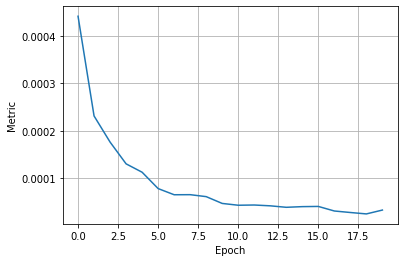

END OF EPOCH 19


In [27]:
# TRAIN

for n in range(TaskConfig.num_epochs):

    train_epoch(model, opt, train_loader,
                melspec_train, config.device)

    au_fa_fr = validation(model, val_loader,
                          melspec_val, config.device)
    history['val_metric'].append(au_fa_fr)

    clear_output()
    plt.plot(history['val_metric'])
    plt.ylabel('Metric')
    plt.xlabel('Epoch')
    plt.grid()
    plt.show()

    print('END OF EPOCH', n)

In [28]:
history

defaultdict(list,
            {'val_metric': [0.00044107337681586876,
              0.00023113505291200655,
              0.00017613216685680765,
              0.00013031333652895508,
              0.00011266133078399702,
              7.82405163360869e-05,
              6.526706789472828e-05,
              6.542222413183745e-05,
              6.129268120570122e-05,
              4.69765345585902e-05,
              4.318714184457791e-05,
              4.3658578103486524e-05,
              4.1945891947704585e-05,
              3.883679965794018e-05,
              4.0239173339503774e-05,
              4.0674804312925667e-05,
              3.106108515973857e-05,
              2.7886349846581816e-05,
              2.4914511151183194e-05,
              3.3042310956670975e-05]})

### Reproduce

In [29]:
history = defaultdict(list)
config = TaskConfig()
model = CRNN(config).to(config.device)

print(model)

opt = torch.optim.Adam(
    model.parameters(),
    lr=config.learning_rate,
    weight_decay=config.weight_decay
)

CRNN(
  (conv): Sequential(
    (0): Conv2d(1, 8, kernel_size=(5, 20), stride=(2, 8))
    (1): Flatten(start_dim=1, end_dim=2)
  )
  (gru): GRU(144, 64, num_layers=2, batch_first=True, dropout=0.1)
  (attention): Attention(
    (energy): Sequential(
      (0): Linear(in_features=64, out_features=64, bias=True)
      (1): Tanh()
      (2): Linear(in_features=64, out_features=1, bias=True)
    )
  )
  (classifier): Linear(in_features=64, out_features=2, bias=True)
)


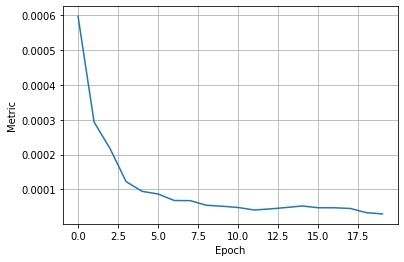

END OF EPOCH 19


In [30]:
# TRAIN

for n in range(TaskConfig.num_epochs):

    train_epoch(model, opt, train_loader,
                melspec_train, config.device)

    au_fa_fr = validation(model, val_loader,
                          melspec_val, config.device)
    history['val_metric'].append(au_fa_fr)

    clear_output()
    plt.plot(history['val_metric'])
    plt.ylabel('Metric')
    plt.xlabel('Epoch')
    plt.grid()
    plt.show()

    print('END OF EPOCH', n)

In [66]:
validation(model, val_loader, melspec_val, config.device)

102it [00:25,  4.04it/s]


2.9282755980564294e-05

In [31]:
history

defaultdict(list,
            {'val_metric': [0.0005975096528811842,
              0.00029343326588512686,
              0.00021689946815724067,
              0.00012216166653314278,
              9.416790083010079e-05,
              8.652347237868387e-05,
              6.78808537352596e-05,
              6.743328766667546e-05,
              5.427484525030207e-05,
              5.136864957829579e-05,
              4.769860781590593e-05,
              4.055545336130323e-05,
              4.367648074622989e-05,
              4.774634819655491e-05,
              5.2132495668679375e-05,
              4.695266436826571e-05,
              4.694669682068459e-05,
              4.4935633285846576e-05,
              3.2887154719561814e-05,
              2.9282755980564294e-05]})

In [62]:
torch.save(model.state_dict(), 'CRNN_Model.pth')

# Streaming

In [607]:
class Streaming(CRNN):
    def __init__(self, config, max_window_length, streaming_step_size):
        super().__init__(config)
        self.max_window_length = max_window_length
        self.streaming_step_size = streaming_step_size
        self.buffer = []
        self.last_hidden = torch.zeros(self.config.gru_num_layers, 1, self.config.hidden_size)
        
        self.num_strides_del = self.config.kernel_size[1] // self.config.stride[1] + 1
        self.grus = []
        self.alphas = []
        
    def forward(self, mel_spec): 
        
        if len(self.buffer) * self.streaming_step_size < self.max_window_length:
            self.buffer.append(mel_spec)
            return None
        
        else:
            
            self.buffer.append(mel_spec)
            to_conv = torch.cat(self.buffer, dim=1)[:, -(self.config.kernel_size[1] -1 + self.streaming_step_size):]
            tc = to_conv.unsqueeze(0).unsqueeze(0)
            conv_output = self.conv(tc).transpose(-1, -2)
            gru_output, self.last_hidden = self.gru(conv_output, self.last_hidden)
            self.grus.extend([g for g in gru_output])
            new_alphas = self.attention.energy(gru_output)
            self.alphas.extend([nw for nw in new_alphas])
            c = (torch.cat(self.alphas).unsqueeze(0) * torch.cat(self.grus))
            c2 = self.classifier((c.sum(dim=1)))
            output = c2
            del self.buffer[0]
            del self.grus[self.num_strides_del:]
            del self.alphas[self.num_strides_del:]
            return output
        

In [615]:
ss = 20

In [616]:
s = Streaming(config, max_window_length=40, streaming_step_size=ss)
s.load_state_dict(torch.load('CRNN_Model.pth'))

<All keys matched successfully>

In [623]:
x = torch.cat((melspec_val(val_set[0]['wav']), melspec_val(val_set[59]['wav']), melspec_val(val_set[1]['wav'])), dim=1)
print(val_set[0]['label'], val_set[44]['label'], val_set[1]['label'])
print(val_set[0]['keywors'], val_set[44]['keywors'], val_set[1]['keywors'])

0 1 0
three sheila seven


In [624]:
result = []
for i in range(0, x.shape[1], ss):
    if i+ss < x.shape[1]:
        output = s(x[:, i:i+ss])
        if output == None:
            pass
        else:
            result.append(F.softmax(output, dim=-1)[0][1])

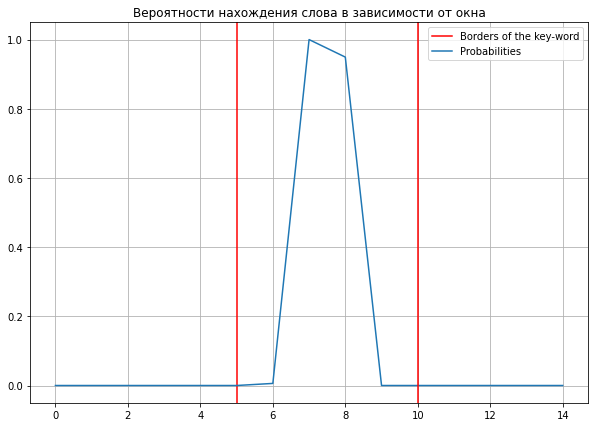

In [626]:
plt.figure(figsize=(10, 7))
plt.grid()
plt.title('Probabilities of keyword in audio')
plt.axvline(x = melspec_val(val_set[0]['wav']).shape[-1] // ss, color = 'red', linestyle = '-')
plt.plot(result)
plt.axvline(x = (melspec_val(val_set[0]['wav']).shape[-1] + melspec_val(val_set[59]['wav']).shape[-1]) // ss, color = 'red', linestyle = '-')
plt.legend(['Borders of the key-word', 'Probabilities'])

# Distillation

## Base Distillation


In [627]:
%pip install thop

Defaulting to user installation because normal site-packages is not writeable
You should consider upgrading via the '/usr/local/bin/python3 -m pip install --upgrade pip' command.


In [628]:
from thop import profile

In [631]:
#!g1.1
@dataclasses.dataclass
class TaskConfig:
    keyword: str = 'sheila'  # We will use 1 key word -- 'sheila'
    batch_size: int = 128
    learning_rate: float = 3e-4
    weight_decay: float = 1e-5
    num_epochs: int = 20
    n_mels: int = 40
    cnn_out_channels: int = 8
    kernel_size: Tuple[int, int] = (5, 20)
    stride: Tuple[int, int] = (2, 8)
    hidden_size: int = 64
    gru_num_layers: int = 2
    bidirectional: bool = False
    num_classes: int = 2
    sample_rate: int = 16000
    device: torch.device = torch.device(
        'cuda:0' if torch.cuda.is_available() else 'cpu')
        

config = TaskConfig()
teacher_model = CRNN(config).to(config.device)
teacher_model.load_state_dict(torch.load('CRNN_Model.pth'))

profile(teacher_model, (torch.randn(1, 40, 101).cuda(), ))  

[INFO] Register count_convNd() for <class 'torch.nn.modules.conv.Conv2d'>.
[WARN] Cannot find rule for <class 'torch.nn.modules.flatten.Flatten'>. Treat it as zero Macs and zero Params.
[WARN] Cannot find rule for <class 'torch.nn.modules.container.Sequential'>. Treat it as zero Macs and zero Params.
[INFO] Register count_gru() for <class 'torch.nn.modules.rnn.GRU'>.
[INFO] Register count_linear() for <class 'torch.nn.modules.linear.Linear'>.
[WARN] Cannot find rule for <class 'torch.nn.modules.activation.Tanh'>. Treat it as zero Macs and zero Params.
[WARN] Cannot find rule for <class '__main__.Attention'>. Treat it as zero Macs and zero Params.
[WARN] Cannot find rule for <class '__main__.CRNN'>. Treat it as zero Macs and zero Params.


(933808.0, 70443.0)

In [632]:
#!g1.1
from thop import clever_format
macs, params = profile(teacher_model, (torch.randn(1, 40, 101).cuda(), ))
macs, params = clever_format([macs, params], "%.3f")

[INFO] Register count_convNd() for <class 'torch.nn.modules.conv.Conv2d'>.
[WARN] Cannot find rule for <class 'torch.nn.modules.flatten.Flatten'>. Treat it as zero Macs and zero Params.
[WARN] Cannot find rule for <class 'torch.nn.modules.container.Sequential'>. Treat it as zero Macs and zero Params.
[INFO] Register count_gru() for <class 'torch.nn.modules.rnn.GRU'>.
[INFO] Register count_linear() for <class 'torch.nn.modules.linear.Linear'>.
[WARN] Cannot find rule for <class 'torch.nn.modules.activation.Tanh'>. Treat it as zero Macs and zero Params.
[WARN] Cannot find rule for <class '__main__.Attention'>. Treat it as zero Macs and zero Params.
[WARN] Cannot find rule for <class '__main__.CRNN'>. Treat it as zero Macs and zero Params.


In [711]:
print(macs, params)

933.808K 70.443K


In [744]:
#!g1.1

def train_epoch(model, student_model, opt, loader, log_melspec, device, alpha=0.1):
    # alpha - просто вес с лоссом
    model.eval()
    student_model.train()
    
    mse_losses = []
    cres = []
    for i, (batch, labels) in tqdm(enumerate(loader), total=len(loader)):
        
        batch, labels = batch.to(device), labels.to(device)
        batch = log_melspec(batch)

        opt.zero_grad()
        # run model # with autocast():
        logits_teacher = model(batch).detach()
        logits_student = student_model(batch)
        
        probs = F.softmax(logits_student, dim=-1)
        mse = F.mse_loss(logits_student, logits_teacher)
        cre = F.cross_entropy(logits_student, labels)
        loss = (mse * alpha) + (cre * (1. - alpha))
        
        ###
        mse_losses.append(mse.detach().cpu().numpy())
        cres.append(cre.detach().cpu().numpy())
        
        loss.backward()
        torch.nn.utils.clip_grad_norm_(student_model.parameters(), 5)

        opt.step()

        # logging
        argmax_probs = torch.argmax(probs, dim=-1)
        FA, FR = count_FA_FR(argmax_probs, labels)
        acc = torch.sum(argmax_probs == labels) / torch.numel(argmax_probs)
        ####


    return acc, np.mean(mse_losses), np.mean(cres)

In [745]:
#!g1.1
@dataclasses.dataclass
class TaskConfig:
    keyword: str = 'sheila'  # We will use 1 key word -- 'sheila'
    batch_size: int = 128
    learning_rate: float = 3e-4
    weight_decay: float = 1e-5
    num_epochs: int = 20
    n_mels: int = 40
    cnn_out_channels: int = 8
    kernel_size: Tuple[int, int] = (5, 20)
    stride: Tuple[int, int] = (2, 8)
    hidden_size: int = 64
    gru_num_layers: int = 2
    bidirectional: bool = False
    num_classes: int = 2
    sample_rate: int = 16000
    device: torch.device = torch.device(
        'cuda' if torch.cuda.is_available() else 'cpu')

In [746]:
#!g1.1
sum([param.numel() for param in student_model.parameters()])

9047

In [747]:
#!g1.1
macs, params = profile(student_model, (torch.randn(1, 40, 101).cuda(), ))
macs, params = clever_format([macs, params], "%.3f")

[INFO] Register count_convNd() for <class 'torch.nn.modules.conv.Conv2d'>.
[WARN] Cannot find rule for <class 'torch.nn.modules.flatten.Flatten'>. Treat it as zero Macs and zero Params.
[WARN] Cannot find rule for <class 'torch.nn.modules.container.Sequential'>. Treat it as zero Macs and zero Params.
[INFO] Register count_gru() for <class 'torch.nn.modules.rnn.GRU'>.
[INFO] Register count_linear() for <class 'torch.nn.modules.linear.Linear'>.
[WARN] Cannot find rule for <class 'torch.nn.modules.activation.Tanh'>. Treat it as zero Macs and zero Params.
[WARN] Cannot find rule for <class '__main__.Attention'>. Treat it as zero Macs and zero Params.
[WARN] Cannot find rule for <class '__main__.CRNN'>. Treat it as zero Macs and zero Params.


In [639]:
#!g1.1
teacher_metrics = history['val_metric']

[0.0005975096528811842,
 0.00029343326588512686,
 0.00021689946815724067,
 0.00012216166653314278,
 9.416790083010079e-05,
 8.652347237868387e-05,
 6.78808537352596e-05,
 6.743328766667546e-05,
 5.427484525030207e-05,
 5.136864957829579e-05,
 4.769860781590593e-05,
 4.055545336130323e-05,
 4.367648074622989e-05,
 4.774634819655491e-05,
 5.2132495668679375e-05,
 4.695266436826571e-05,
 4.694669682068459e-05,
 4.4935633285846576e-05,
 3.2887154719561814e-05,
 2.9282755980564294e-05]

In [748]:
#!g1.1
config = TaskConfig()
teacher_model = CRNN(config).to(config.device)
teacher_model.load_state_dict(torch.load('CRNN_Model.pth'))

<All keys matched successfully>

In [764]:
#!g1.1
profile(student_model, (torch.randn(1, 40, 101).cuda(), )) 

[INFO] Register count_convNd() for <class 'torch.nn.modules.conv.Conv2d'>.
[WARN] Cannot find rule for <class 'torch.nn.modules.flatten.Flatten'>. Treat it as zero Macs and zero Params.
[WARN] Cannot find rule for <class 'torch.nn.modules.container.Sequential'>. Treat it as zero Macs and zero Params.
[INFO] Register count_gru() for <class 'torch.nn.modules.rnn.GRU'>.
[INFO] Register count_linear() for <class 'torch.nn.modules.linear.Linear'>.
[WARN] Cannot find rule for <class 'torch.nn.modules.activation.Tanh'>. Treat it as zero Macs and zero Params.
[WARN] Cannot find rule for <class '__main__.Attention'>. Treat it as zero Macs and zero Params.
[WARN] Cannot find rule for <class '__main__.CRNN'>. Treat it as zero Macs and zero Params.


/home/jupyter/.local/lib/python3.7/site-packages/torch/nn/modules/rnn.py:838: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at  ../aten/src/ATen/native/cudnn/RNN.cpp:924.)
  self.dropout, self.training, self.bidirectional, self.batch_first)


(177492.0, 9047.0)

In [753]:
#!g1.1
config = TaskConfig()
teacher_model = CRNN(config).to(config.device)
teacher_model.load_state_dict(torch.load('CRNN_Model.pth'))

сonfig = TaskConfig()
config.cnn_out_channels = 4
config.hidden_size = 20
student_model = CRNN(config).to(config.device)


opt = torch.optim.Adam(
    student_model.parameters(),
    lr=config.learning_rate,
    weight_decay=config.weight_decay
)
melspec_train = LogMelspec(is_train=True, config=TaskConfig)
melspec_val = LogMelspec(is_train=False, config=TaskConfig)

In [754]:
#!g1.1
student_metrics3 = []
accs_train = []
cres_train = []
mses_train = []
train_ces = []


for n in range(TaskConfig.num_epochs):

    accs, mse_losses, cres = train_epoch(teacher_model, student_model, opt, train_loader, melspec_train, config.device, alpha=0.5)

    au_fa_fr = validation(student_model, val_loader,
                          melspec_val, config.device)
    student_metrics3.append(au_fa_fr)
    mses_train.append(mse_losses)
    cres_train.append(cres)
    accs_train.append(accs)
    print(accs)
    print(au_fa_fr)

100%|██████████| 405/405 [01:11<00:00,  5.69it/s]
102it [00:14,  6.86it/s]
100%|██████████| 405/405 [01:11<00:00,  5.64it/s]
102it [00:14,  6.92it/s]
100%|██████████| 405/405 [01:10<00:00,  5.73it/s]
102it [00:11,  8.57it/s]
100%|██████████| 405/405 [01:12<00:00,  5.62it/s]
102it [00:14,  6.95it/s]
100%|██████████| 405/405 [01:10<00:00,  5.73it/s]
102it [00:11,  8.59it/s]
100%|██████████| 405/405 [01:12<00:00,  5.59it/s]
102it [00:14,  6.90it/s]
100%|██████████| 405/405 [01:10<00:00,  5.71it/s]
102it [00:11,  8.66it/s]
100%|██████████| 405/405 [01:12<00:00,  5.60it/s]
102it [00:14,  6.93it/s]
100%|██████████| 405/405 [01:10<00:00,  5.77it/s]
102it [00:11,  8.64it/s]
100%|██████████| 405/405 [01:12<00:00,  5.61it/s]
102it [00:14,  6.96it/s]
100%|██████████| 405/405 [01:10<00:00,  5.73it/s]
102it [00:11,  8.60it/s]
100%|██████████| 405/405 [01:12<00:00,  5.62it/s]
102it [00:15,  6.54it/s]
100%|██████████| 405/405 [01:10<00:00,  5.72it/s]
102it [00:12,  8.47it/s]
100%|██████████| 405/405 

tensor(0.6719, device='cuda:0')
0.001175970893883428
tensor(0.9531, device='cuda:0')
0.0008208302022357118
tensor(0.8594, device='cuda:0')
0.0007051105033163899
tensor(0.5938, device='cuda:0')
0.0005576106297538043
tensor(0.8281, device='cuda:0')
0.0004402588065710457
tensor(0.8125, device='cuda:0')
0.0003376945662943066
tensor(0.7500, device='cuda:0')
0.00029434928443882895
tensor(0.7656, device='cuda:0')
0.00027234096895965203
tensor(0.8750, device='cuda:0')
0.0002518603456612423
tensor(0.6875, device='cuda:0')
0.00021191059837942294
tensor(0.8125, device='cuda:0')
0.0002072648625875197
tensor(0.6406, device='cuda:0')
0.0001903707353853641
tensor(0.6875, device='cuda:0')
0.0001623053591113486
tensor(0.8281, device='cuda:0')
0.00014798324491665648
tensor(0.8281, device='cuda:0')
0.0001578834063537374
tensor(0.9531, device='cuda:0')
0.00014880975025664182
tensor(0.9062, device='cuda:0')
0.00012428611347202213
tensor(0.9219, device='cuda:0')
0.00010597767749314068
tensor(0.9531, device=

In [759]:
#!g1.1
print(student_metrics3[-1])

8.807503474977551e-05


In [761]:
#!g1.1
torch.save(student_model.state_dict(), 'student1.pth')

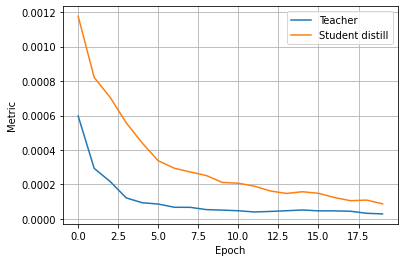

In [763]:
plt.plot(teacher_metrics)
plt.plot(student_metrics3)
plt.legend(['Teacher', 'Student distill'])
plt.ylabel('Metric')
plt.xlabel('Epoch')
plt.grid()
plt.show()

In [808]:
#!g1.1
config = TaskConfig()
teacher = CRNN(config).to(config.device)
teacher.load_state_dict(torch.load('CRNN_Model.pth'))

config = TaskConfig()
config.cnn_out_channels = 3
config.kernel_size = (3, 20)
config.hidden_size = 18
config.gru_num_layers = 2


student_model = CRNN(config).to(config.device)
profile(student_model, (torch.randn(1, 40, 101).cuda(), )) 

opt = torch.optim.Adam(
    student_model.parameters(),
    lr=config.learning_rate,
    weight_decay=config.weight_decay
)


[INFO] Register count_convNd() for <class 'torch.nn.modules.conv.Conv2d'>.
[WARN] Cannot find rule for <class 'torch.nn.modules.flatten.Flatten'>. Treat it as zero Macs and zero Params.
[WARN] Cannot find rule for <class 'torch.nn.modules.container.Sequential'>. Treat it as zero Macs and zero Params.
[INFO] Register count_gru() for <class 'torch.nn.modules.rnn.GRU'>.
[INFO] Register count_linear() for <class 'torch.nn.modules.linear.Linear'>.
[WARN] Cannot find rule for <class 'torch.nn.modules.activation.Tanh'>. Treat it as zero Macs and zero Params.
[WARN] Cannot find rule for <class '__main__.Attention'>. Treat it as zero Macs and zero Params.
[WARN] Cannot find rule for <class '__main__.CRNN'>. Treat it as zero Macs and zero Params.


In [817]:
#!g1.1
sum([param.numel() for param in student_model.parameters()])

6792

In [809]:
#!g1.1
student_metrics32 = []
accs_train = []
cres_train = []
mses_train = []
train_ces = []


for n in range(TaskConfig.num_epochs):

    accs, mse_losses, cres = train_epoch(teacher_model, student_model, opt, train_loader, melspec_train, config.device, alpha=0.5)

    au_fa_fr = validation(student_model, val_loader,
                          melspec_val, config.device)
    student_metrics32.append(au_fa_fr)
    mses_train.append(mse_losses)
    cres_train.append(cres)
    accs_train.append(accs)
    print(accs)
    print(au_fa_fr)

 self.batch_first)
 55%|█████▍    | 222/405 [00:51<00:39,  4.58it/s]/home/jupyter/.local/lib/python3.7/site-packages/torch/nn/modules/rnn.py:838: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at  ../aten/src/ATen/native/cudnn/RNN.cpp:924.)
  self.dropout, self.training, self.bidirectional, self.batch_first)
 55%|█████▌    | 223/405 [00:51<00:40,  4.53it/s]/home/jupyter/.local/lib/python3.7/site-packages/torch/nn/modules/rnn.py:838: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at  ../aten/src/ATen/native/cudnn/RNN.cpp:924.)
  self.dropout, self.training, self.bidirectional, self.batc

tensor(0.4844, device='cuda:0')
0.0020298911474564596
tensor(0.5938, device='cuda:0')
0.0012309886988075796
tensor(0.7500, device='cuda:0')
0.0008036914055827303
tensor(0.5781, device='cuda:0')
0.0007036961945396642
tensor(0.7812, device='cuda:0')
0.0005337493907506891
tensor(0.6719, device='cuda:0')
0.00043643360857154663
tensor(0.8906, device='cuda:0')
0.0004074820514817346
tensor(0.9688, device='cuda:0')
0.0003794256265290908
tensor(0.9219, device='cuda:0')
0.0003055294848320605
tensor(0.6250, device='cuda:0')
0.0003159010825280501
tensor(0.7188, device='cuda:0')
0.000265302246587719
tensor(0.7344, device='cuda:0')
0.00021622811905436452
tensor(0.7812, device='cuda:0')
0.00019408553375461235
tensor(0.9219, device='cuda:0')
0.00016898602862841435
tensor(0.8906, device='cuda:0')
0.00016828484178763256
tensor(0.9219, device='cuda:0')
0.0001303252716241173
tensor(0.7812, device='cuda:0')
0.00012591525396166836
tensor(0.9531, device='cuda:0')
0.0001226331027920514
tensor(0.8125, device='

In [811]:
#!g1.1
torch.save(student_model.state_dict(), 'student32.pth')

In [818]:
#!g1.1
sum([param.numel() for param in student_model.parameters()])

6792

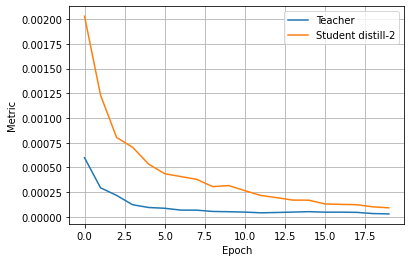

In [814]:
#!g1.1
plt.plot(teacher_metrics)
plt.plot(student_metrics32)
plt.legend(['Teacher', 'Student distill-2'])
plt.ylabel('Metric')
plt.xlabel('Epoch')
plt.grid()
plt.show()

## + Attention Layer Distillation


In [767]:
#!g1.1
class CRNNwithAttention(CRNN):
    def __init__(self, config: TaskConfig):
        super().__init__(config)
        
    def forward(self, x):
        
        x = x.unsqueeze(dim=1)
        conv_output = self.conv(x).transpose(-1, -2)
        gru_output, _ = self.gru(conv_output)
        alphas = self.attention.energy(gru_output)
        alphas_softmax = torch.softmax(alphas, dim=-2)
        cv = (gru_output * alphas_softmax).sum(dim=-2)
        output = self.classifier(cv)
        #возвращаем выходы классификатора и аттеншн-слоя, красата
        return output, alphas

In [824]:
#!g1.1
def train_epoch_distil_attention(model, student_model, opt, loader, log_melspec, device, alpha=0.5):
    # alpha - просто вес с лоссом
    model.eval()
    student_model.train()
    
    mse_losses = []
    cres = []
    mse_atts = []
    for i, (batch, labels) in tqdm(enumerate(loader), total=len(loader)):
        
        batch, labels = batch.to(device), labels.to(device)
        batch = log_melspec(batch)

        opt.zero_grad()
        # run model # with autocast():
        logits_teacher, alphas_teacher = model(batch)
        logits_student, alphas_student = student_model(batch)
        logits_teacher = logits_teacher.detach()
        alphas_teacher = alphas_teacher.detach()
        
        
        probs = F.softmax(logits_student, dim=-1)
        mse = F.mse_loss(logits_student, logits_teacher)
        cre = F.cross_entropy(logits_student, labels)
        mse_att = F.mse_loss(alphas_teacher, alphas_student)
        loss = (mse * alpha) + (cre * alpha) + mse_att
        
        ###
        mse_losses.append(mse.detach().cpu().numpy())
        cres.append(cre.detach().cpu().numpy())
        mse_atts.append(mse_att.detach().cpu().numpy())
        
        loss.backward()
        torch.nn.utils.clip_grad_norm_(student_model.parameters(), 5)

        opt.step()

        # logging
        argmax_probs = torch.argmax(probs, dim=-1)
        FA, FR = count_FA_FR(argmax_probs, labels)
        acc = torch.sum(argmax_probs == labels) / torch.numel(argmax_probs)
        ####


    return acc, np.mean(mse_losses), np.mean(cres), np.mean(mse_atts)

@torch.no_grad()
def val_epoch_distil_attention(model, loader, log_melspec, device):
    val_losses, accs, FAs, FRs = [], [], [], []
    all_probs, all_labels = [], []
    for i, (batch, labels) in tqdm(enumerate(loader)):
        batch, labels = batch.to(device), labels.to(device)
        batch = log_melspec(batch)

        output, _ = model(batch)
        probs = F.softmax(output, dim=-1)
        loss = F.cross_entropy(output, labels)
        argmax_probs = torch.argmax(probs, dim=-1)
        print(probs)
        all_probs.append(probs[:, 1].cpu())
        all_labels.append(labels.cpu())
        val_losses.append(loss.item())
        accs.append(
            torch.sum(argmax_probs == labels).item() /  # ???
            torch.numel(argmax_probs)
        )
        FA, FR = count_FA_FR(argmax_probs, labels)
        FAs.append(FA)
        FRs.append(FR)
        au_fa_fr = get_au_fa_fr(torch.cat(all_probs, dim=0).cpu(), all_labels)
        return au_fa_fr

In [793]:
#!g1.1
config = TaskConfig()
teacher = CRNNwithAttention(config).to(config.device)
teacher.load_state_dict(torch.load('CRNN_Model.pth'))

<All keys matched successfully>

In [794]:
#!g1.1
config = TaskConfig()
config.cnn_out_channels = 2
config.hidden_size = 20
config.gru_num_layers = 1
student_model = CRNNwithAttention(config).to(config.device)


/home/jupyter/.local/lib/python3.7/site-packages/torch/nn/modules/rnn.py:65: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1
  "num_layers={}".format(dropout, num_layers))


In [795]:
#!g1.1
profile(student_model, (torch.randn(1, 40, 101).cuda(), )) 

[INFO] Register count_convNd() for <class 'torch.nn.modules.conv.Conv2d'>.
[WARN] Cannot find rule for <class 'torch.nn.modules.flatten.Flatten'>. Treat it as zero Macs and zero Params.
[WARN] Cannot find rule for <class 'torch.nn.modules.container.Sequential'>. Treat it as zero Macs and zero Params.
[INFO] Register count_gru() for <class 'torch.nn.modules.rnn.GRU'>.
[INFO] Register count_linear() for <class 'torch.nn.modules.linear.Linear'>.
[WARN] Cannot find rule for <class 'torch.nn.modules.activation.Tanh'>. Treat it as zero Macs and zero Params.
[WARN] Cannot find rule for <class '__main__.Attention'>. Treat it as zero Macs and zero Params.
[WARN] Cannot find rule for <class '__main__.CRNNwithAttention'>. Treat it as zero Macs and zero Params.


(84476.0, 4165.0)

In [797]:
#!g1.1


opt = torch.optim.Adam(
    student_model.parameters(),
    lr=config.learning_rate,
    weight_decay=config.weight_decay
)

student_metrics4 = []
accs_train = []
cres_train = []
mses_train = []
train_ces = []
mse_atts_list = []
# TaskConfig.num_epochs
for n in range(TaskConfig.num_epochs):

    accs, mse_losses, cres, mse_atts = train_epoch_distil_attention(teacher, student_model, opt, train_loader, melspec_train,
                                                                    config.device, alpha=0.5)

    au_fa_fr = val_epoch_distil_attention(student_model, val_loader,
                          melspec_val, config.device)
    student_metrics4.append(au_fa_fr)
    mses_train.append(mse_losses)
    cres_train.append(cres)
    accs_train.append(accs)
    mse_atts_list.append(mse_atts)
    print(n, au_fa_fr)

100%|██████████| 405/405 [01:29<00:00,  4.55it/s]
0it [00:00, ?it/s]
100%|██████████| 405/405 [01:30<00:00,  4.50it/s]
0it [00:00, ?it/s]
100%|██████████| 405/405 [01:29<00:00,  4.54it/s]
0it [00:00, ?it/s]
100%|██████████| 405/405 [01:30<00:00,  4.49it/s]
0it [00:00, ?it/s]
100%|██████████| 405/405 [01:29<00:00,  4.54it/s]
0it [00:00, ?it/s]
100%|██████████| 405/405 [01:30<00:00,  4.46it/s]
0it [00:00, ?it/s]
100%|██████████| 405/405 [01:29<00:00,  4.53it/s]
0it [00:00, ?it/s]
100%|██████████| 405/405 [01:30<00:00,  4.47it/s]
0it [00:00, ?it/s]
100%|██████████| 405/405 [01:29<00:00,  4.54it/s]
0it [00:00, ?it/s]
100%|██████████| 405/405 [01:30<00:00,  4.48it/s]
0it [00:00, ?it/s]
100%|██████████| 405/405 [01:28<00:00,  4.57it/s]
0it [00:00, ?it/s]
100%|██████████| 405/405 [01:30<00:00,  4.49it/s]
0it [00:00, ?it/s]
100%|██████████| 405/405 [01:29<00:00,  4.54it/s]
0it [00:00, ?it/s]
100%|██████████| 405/405 [01:30<00:00,  4.48it/s]
0it [00:00, ?it/s]
100%|██████████| 405/405 [01:29<00

0 1.7088275
-0.0
1 1.6633548
6.103515625e-05
2 1.6212746
6.103515625e-05
3 1.5461599
6.103515625e-05
4 1.5418508
6.103515625e-05
5 1.4117151
0.0001220703125
6 1.4181551
-0.0
7 1.3601241
-0.0
8 1.2902108
-0.0
9 1.2634957
6.103515625e-05
10 1.2500287
0.0001220703125
11 1.2060695
6.103515625e-05
12 1.1710997
0.0001220703125
13 1.1641366
0.00018310546875
14 1.0755723
0.0001220703125
15 1.1371413
0.0001220703125
16 1.0968562
0.00018310546875
17 1.0841584
6.103515625e-05
18 1.0284449
6.103515625e-05
19 1.0012472
6.103515625e-05


In [825]:
#!g1.1
val_epoch_distil_attention(student_model, val_loader,
                          melspec_val, config.device)

tensor([[9.9972e-01, 2.7920e-04],
        [9.9949e-01, 5.0937e-04],
        [9.9990e-01, 1.0320e-04],
        [9.9959e-01, 4.1434e-04],
        [1.1266e-03, 9.9887e-01],
        [9.9808e-01, 1.9152e-03],
        [9.9929e-01, 7.0588e-04],
        [9.8637e-01, 1.3625e-02],
        [9.9126e-01, 8.7356e-03],
        [9.9980e-01, 1.9529e-04],
        [9.7629e-01, 2.3705e-02],
        [9.9970e-01, 3.0473e-04],
        [9.9928e-01, 7.2176e-04],
        [9.9938e-01, 6.2292e-04],
        [9.9981e-01, 1.9187e-04],
        [9.9966e-01, 3.3626e-04],
        [9.9979e-01, 2.0924e-04],
        [9.9925e-01, 7.5263e-04],
        [9.9964e-01, 3.6246e-04],
        [9.9958e-01, 4.2105e-04],
        [9.8368e-01, 1.6316e-02],
        [9.9967e-01, 3.2608e-04],
        [9.9974e-01, 2.6251e-04],
        [9.9972e-01, 2.7828e-04],
        [7.2171e-01, 2.7829e-01],
        [9.9978e-01, 2.1547e-04],
        [9.9959e-01, 4.1167e-04],
        [9.9953e-01, 4.6856e-04],
        [9.9954e-01, 4.5947e-04],
        [9.989

0it [00:00, ?it/s]/home/jupyter/.local/lib/python3.7/site-packages/torch/nn/modules/rnn.py:838: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at  ../aten/src/ATen/native/cudnn/RNN.cpp:924.)
  self.dropout, self.training, self.bidirectional, self.batch_first)
0it [00:03, ?it/s]


6.103515625e-05

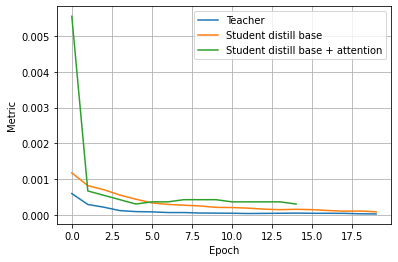

In [786]:
#!g1.1
plt.plot(teacher_metrics)
plt.plot(student_metrics3)
plt.plot(student_metrics4)
plt.legend(['Teacher', 'Student distill base', 'Student distill base + attention'])
plt.ylabel('Metric')
plt.xlabel('Epoch')
plt.grid()
plt.show()

In [819]:
#!g1.1

config = TaskConfig()
teacher = CRNNwithAttention(config).to(config.device)
teacher.load_state_dict(torch.load('CRNN_Model.pth'))

config = TaskConfig()
config.cnn_out_channels = 3
config.kernel_size = (3, 20)
config.hidden_size = 18
config.gru_num_layers = 2


student_model = CRNNwithAttention(config).to(config.device)
profile(student_model, (torch.randn(1, 40, 101).cuda(), )) 

[INFO] Register count_convNd() for <class 'torch.nn.modules.conv.Conv2d'>.
[WARN] Cannot find rule for <class 'torch.nn.modules.flatten.Flatten'>. Treat it as zero Macs and zero Params.
[WARN] Cannot find rule for <class 'torch.nn.modules.container.Sequential'>. Treat it as zero Macs and zero Params.
[INFO] Register count_gru() for <class 'torch.nn.modules.rnn.GRU'>.
[INFO] Register count_linear() for <class 'torch.nn.modules.linear.Linear'>.
[WARN] Cannot find rule for <class 'torch.nn.modules.activation.Tanh'>. Treat it as zero Macs and zero Params.
[WARN] Cannot find rule for <class '__main__.Attention'>. Treat it as zero Macs and zero Params.
[WARN] Cannot find rule for <class '__main__.CRNNwithAttention'>. Treat it as zero Macs and zero Params.


(113127.0, 6792.0)

In [820]:
#!g1.1
#!g1.1
opt = torch.optim.Adam(
    student_model.parameters(),
    lr=config.learning_rate,
    weight_decay=config.weight_decay
)

student_metrics4 = []
accs_train = []
cres_train = []
mses_train = []
train_ces = []
mse_atts_list = []
# TaskConfig.num_epochs
for n in range(TaskConfig.num_epochs):

    accs, mse_losses, cres, mse_atts = train_epoch_distil_attention(teacher, student_model, opt, train_loader, melspec_train,
                                                                    config.device, alpha=0.5)

    au_fa_fr = val_epoch_distil_attention(student_model, val_loader,
                          melspec_val, config.device)
    student_metrics4.append(au_fa_fr)
    mses_train.append(mse_losses)
    cres_train.append(cres)
    accs_train.append(accs)
    mse_atts_list.append(mse_atts)
    print(n, au_fa_fr)
    
torch.save(student_model.state_dict(), 'student4.pth')

100%|██████████| 405/405 [01:27<00:00,  4.61it/s]
0it [00:00, ?it/s]
100%|██████████| 405/405 [01:26<00:00,  4.71it/s]
0it [00:00, ?it/s]
100%|██████████| 405/405 [01:28<00:00,  4.58it/s]
0it [00:00, ?it/s]
100%|██████████| 405/405 [01:26<00:00,  4.67it/s]
0it [00:00, ?it/s]
100%|██████████| 405/405 [01:28<00:00,  4.60it/s]
0it [00:00, ?it/s]
100%|██████████| 405/405 [01:26<00:00,  4.67it/s]
0it [00:00, ?it/s]
100%|██████████| 405/405 [01:27<00:00,  4.61it/s]
0it [00:00, ?it/s]
100%|██████████| 405/405 [01:26<00:00,  4.68it/s]
0it [00:00, ?it/s]
100%|██████████| 405/405 [01:26<00:00,  4.67it/s]
0it [00:00, ?it/s]
100%|██████████| 405/405 [01:27<00:00,  4.63it/s]
0it [00:00, ?it/s]
100%|██████████| 405/405 [01:26<00:00,  4.69it/s]
0it [00:00, ?it/s]
100%|██████████| 405/405 [01:27<00:00,  4.62it/s]
0it [00:00, ?it/s]
100%|██████████| 405/405 [01:26<00:00,  4.68it/s]
0it [00:00, ?it/s]
100%|██████████| 405/405 [01:27<00:00,  4.65it/s]
0it [00:00, ?it/s]
100%|██████████| 405/405 [01:26<00

0 0.00146484375
1 0.00048828125
2 0.0003662109375
3 6.103515625e-05
4 0.0001220703125
5 0.0001220703125
6 6.103515625e-05
7 6.103515625e-05
8 6.103515625e-05
9 -0.0
10 -0.0
11 -0.0
12 -0.0
13 -0.0
14 -0.0
15 6.103515625e-05
16 -0.0
17 -0.0
18 -0.0
19 -0.0


In [ ]:
#!g1.1
torch.save(student_model.state_dict(), 'student4.pth')

In [ ]:
#!g1.1


In [804]:
#!g1.1
opt = torch.optim.Adam(
    student_model.parameters(),
    lr=config.learning_rate,
    weight_decay=config.weight_decay
)

student_metrics4 = []
accs_train = []
cres_train = []
mses_train = []
train_ces = []
mse_atts_list = []
# TaskConfig.num_epochs
for n in range(TaskConfig.num_epochs):

    accs, mse_losses, cres, mse_atts = train_epoch_distil_attention(teacher, student_model, opt, train_loader, melspec_train,
                                                                    config.device, alpha=0.5)

    au_fa_fr = val_epoch_distil_attention(student_model, val_loader,
                          melspec_val, config.device)
    student_metrics4.append(au_fa_fr)
    mses_train.append(mse_losses)
    cres_train.append(cres)
    accs_train.append(accs)
    mse_atts_list.append(mse_atts)
    print(n, mse_losses)
    print(au_fa_fr)

100%|██████████| 405/405 [01:30<00:00,  4.49it/s]
0it [00:00, ?it/s]
100%|██████████| 405/405 [01:28<00:00,  4.58it/s]
0it [00:00, ?it/s]
100%|██████████| 405/405 [01:29<00:00,  4.51it/s]
0it [00:00, ?it/s]
100%|██████████| 405/405 [01:28<00:00,  4.58it/s]
0it [00:00, ?it/s]
100%|██████████| 405/405 [01:29<00:00,  4.51it/s]
0it [00:00, ?it/s]
100%|██████████| 405/405 [01:28<00:00,  4.57it/s]
0it [00:00, ?it/s]
100%|██████████| 405/405 [01:29<00:00,  4.51it/s]
0it [00:00, ?it/s]
100%|██████████| 405/405 [01:28<00:00,  4.58it/s]
0it [00:00, ?it/s]
100%|██████████| 405/405 [01:29<00:00,  4.51it/s]
0it [00:00, ?it/s]
100%|██████████| 405/405 [01:28<00:00,  4.58it/s]
0it [00:00, ?it/s]
100%|██████████| 405/405 [01:28<00:00,  4.58it/s]
0it [00:00, ?it/s]
100%|██████████| 405/405 [01:29<00:00,  4.51it/s]
0it [00:00, ?it/s]
100%|██████████| 405/405 [01:28<00:00,  4.57it/s]
0it [00:00, ?it/s]
100%|██████████| 405/405 [01:29<00:00,  4.52it/s]
0it [00:00, ?it/s]
100%|██████████| 405/405 [01:28<00

0 6.9679656
0.0048828125
1 7.0058846
0.00079345703125
2 6.4730263
0.00018310546875
3 5.5014467
0.0003662109375
4 4.428193
0.000244140625
5 3.449133
0.0003662109375
6 2.6224043
0.00042724609375
7 2.1492608
0.000244140625
8 1.8911475
0.00018310546875
9 1.6401012
0.000244140625
10 1.4984434
0.0001220703125
11 1.4478315
0.0001220703125
12 1.3731737
0.0001220703125
13 1.2713467
6.103515625e-05
14 1.1897453
6.103515625e-05
15 1.0902601
6.103515625e-05
16 1.0931926
6.103515625e-05
17 1.0410961
-0.0
18 0.986872
6.103515625e-05
19 0.9557533
6.103515625e-05


In [ ]:
#!g1.1
val_epoch_distil_attention(student_model, val_loader,
                          melspec_val, config.device)

In [ ]:
#!g1.1
torch.save(student_model.state_dict(), 'student4.pth')

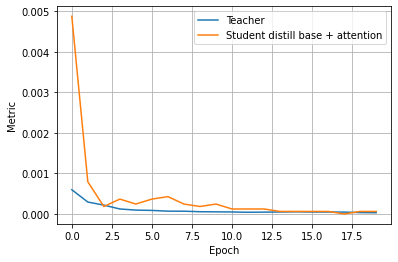

In [805]:
#!g1.1
#!g1.1
plt.plot(teacher_metrics)
plt.plot(student_metrics4)
plt.legend(['Teacher', 'Student distill base + attention'])
plt.ylabel('Metric')
plt.xlabel('Epoch')
plt.grid()
plt.show()

In [821]:
#!g1.1
for n in range(TaskConfig.num_epochs):

    accs, mse_losses, cres, mse_atts = train_epoch_distil_attention(teacher, student_model, opt, train_loader, melspec_train,
                                                                    config.device, alpha=0.5)

    au_fa_fr = val_epoch_distil_attention(student_model, val_loader,
                          melspec_val, config.device)
    student_metrics4.append(au_fa_fr)
    mses_train.append(mse_losses)
    cres_train.append(cres)
    accs_train.append(accs)
    mse_atts_list.append(mse_atts)
    print(n, au_fa_fr)
    
torch.save(student_model.state_dict(), 'student5.pth')

s means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at  ../aten/src/ATen/native/cudnn/RNN.cpp:924.)
  self.dropout, self.training, self.bidirectional, self.batch_first)
/home/jupyter/.local/lib/python3.7/site-packages/torch/nn/modules/rnn.py:838: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at  ../aten/src/ATen/native/cudnn/RNN.cpp:924.)
  self.dropout, self.training, self.bidirectional, self.batch_first)
 69%|██████▉   | 281/405 [00:46<00:20,  6.07it/s]/home/jupyter/.local/lib/python3.7/site-packages/torch/nn/modules/rnn.py:838: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly g

0 -0.0
1 -0.0
2 -0.0
3 -0.0
4 -0.0
5 -0.0
6 -0.0
7 -0.0
8 -0.0
9 -0.0
10 -0.0
11 -0.0
12 -0.0
13 -0.0
14 -0.0
15 -0.0
16 -0.0
17 -0.0
18 -0.0
19 -0.0


In [ ]:
#!g1.1


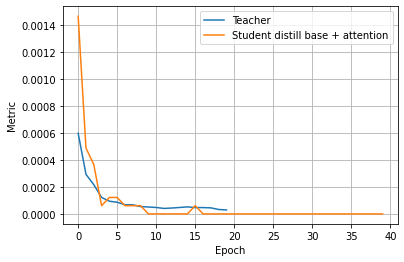

In [822]:
#!g1.1
plt.plot(teacher_metrics)
plt.plot(student_metrics4)
plt.legend(['Teacher', 'Student distill base + attention'])
plt.ylabel('Metric')
plt.xlabel('Epoch')
plt.grid()
plt.show()

# Quantization

In [833]:
#!g1.1
student_model.load_state_dict(torch.load('student4.pth'))
modelq = torch.quantization.quantize_dynamic(
    student_model.to('cpu'),  # the original model
    {nn.Linear, nn.Conv2d, nn.GRU},  # a set of layers to dynamically quantize
    dtype=torch.qint8)
modelq

CRNNwithAttention(
  (conv): Sequential(
    (0): Conv2d(1, 3, kernel_size=(3, 20), stride=(2, 8))
    (1): Flatten(start_dim=1, end_dim=2)
  )
  (gru): DynamicQuantizedGRU(57, 18, num_layers=2, batch_first=True, dropout=0.1)
  (attention): Attention(
    (energy): Sequential(
      (0): DynamicQuantizedLinear(in_features=18, out_features=18, dtype=torch.qint8, qscheme=torch.per_tensor_affine)
      (1): Tanh()
      (2): DynamicQuantizedLinear(in_features=18, out_features=1, dtype=torch.qint8, qscheme=torch.per_tensor_affine)
    )
  )
  (classifier): DynamicQuantizedLinear(in_features=18, out_features=2, dtype=torch.qint8, qscheme=torch.per_tensor_affine)
)

In [848]:
#!g1.1
config = TaskConfig()
config.device='cpu'

In [849]:
#!g1.1
melspec_train = LogMelspec(is_train=True, config=config)
melspec_val = LogMelspec(is_train=False, config=config)


In [ ]:
#!g1.1
val_epoch_distil_attention(modelq, val_loader,
                          melspec_val, 'cpu')

In [ ]:
#!g1.1
